#### Importing the model and getting the output values of the pep-encoder

##### Setting up the constants and imports:

In [10]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
from modelAndPerformances import *
import seaborn as sns

# Device setup
device = "cpu"
# Load model hyperparameters and data
d_model = 64
d_ff = 768
d_k = 32
n_layers = 3
n_heads = 1
dropout = 0.1

#### Using some guidelines for good plots settings from a course at Imperial

In [ ]:
## Code from Methods for Data Science guide for plotting at Imperial College London for settings
# we define a mix of fontsizes, for different parts of a plot
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

# example of how you can use these fontsizes to set a global configuration for matplotlib;
# you should assign them based on the specific appearance of the figures you are producing
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#setting seeds
seed = 6
random.seed(seed )
torch.manual_seed(seed )
np.random.seed(seed ) 

##### Setting up required masks and making data smaller (more maneagable)

In [ ]:
data = pd.read_csv('data/testData/testData.csv')
pep_inputs, hla_inputs, labels, labelsHla = make_data(data, True)

# Filter only positive labels
positive_mask = labels == 1
pep_pos = pep_inputs[positive_mask]
hla_pos = hla_inputs[positive_mask]
labels_pos = labels[positive_mask]
labelsHla_pos = labelsHla[positive_mask]  

# Get a unique list of all HLA alleles
unique_hlas = list(set(labelsHla_pos))

# Randomly select 5 HLA alleles
random_hlas = random.sample(unique_hlas, 5)
selected_hlas = random_hlas
print(f"Selected HLA alleles: {selected_hlas}")
# Add peptide strings to the lists too
pep_pos_seq = np.array(data.peptide)[positive_mask]

pep_list = []
hla_list = []
labels_list = []
labelsHla_list = []
pep_seq_list = []  

for hla in selected_hlas:
    hla_mask = labelsHla_pos == hla

    pep_hla = pep_pos[hla_mask]
    hla_hla = hla_pos[hla_mask]
    labels_hla = labels_pos[hla_mask]
    labelsHla_hla = labelsHla_pos[hla_mask]
    pep_seq_hla = pep_pos_seq[hla_mask]  #

    num_samples_hla = min(200, len(pep_hla))
    indices = torch.randperm(len(pep_hla))[:num_samples_hla]

    pep_list.append(pep_hla[indices])
    hla_list.append(hla_hla[indices])
    labels_list.append(labels_hla[indices])
    labelsHla_list.append(labelsHla_hla[indices])
    pep_seq_list.append(pep_seq_hla[indices]) 
     
pepSmall = torch.cat(pep_list).to(device)
hlaSmall = torch.cat(hla_list).to(device)
labelsSmall = torch.cat(labels_list)
labelsSmallHla = np.concatenate(labelsHla_list)
pepSmallSeq = np.concatenate(pep_seq_list)



Selected HLA alleles: [np.str_('HLA-C*08:02'), np.str_('HLA-C*03:03'), np.str_('HLA-B*27:07'), np.str_('HLA-A*29:02'), np.str_('HLA-A*02:04')]


##### Make hook to store pep_encoder information

In [19]:
colors = ['#9BC995', "#083D77", '#9A031E', '#C4B7CB', '#FC7753']

# Create a seaborn palette from these colors
custom_palette = sns.color_palette(colors)

#percentage of outliers constant
percentageOfOutliers = 5

In [20]:
# Load model
model = Transformer(d_model, d_k, n_layers, n_heads, d_ff, dropout=dropout)
model.load_state_dict(torch.load("model/best_model_final.pt", map_location=device))
model.to(device)
model.eval()

# Hook to extract encoder outputs
pepEncoderOutputs = {}
def get_activation(name):
    def hook(model, input, output):
        pepEncoderOutputs["pep"] = output[0].detach()
    return hook

model.pep_encoder.register_forward_hook(get_activation("pep_encoder"))

# Forward pass
model(pepSmall, hlaSmall)
pepEncoderOutputs = pepEncoderOutputs["pep"]  


##### Make hook to store decoder information

In [21]:
# Extract encoder outputs using forward hook
decOutputs = {}

def get_activation(name):
    def hook(model, input, output):
        decOutputs["dec"] = output[0].detach()
    return hook
# Load and prepare model
model = Transformer(d_model, d_k, n_layers, n_heads, d_ff)
model.load_state_dict(torch.load("model/best_model_final.pt", map_location=device))
model.to(device)
model.eval()
model.decoder.register_forward_hook(get_activation("decoder"))

# Forward pass
model(pepSmall, hlaSmall)
decOutputs = decOutputs["dec"]


##### Prepare both for plotting

In [22]:
# Average over sequence dimension
from sklearn.neighbors import LocalOutlierFactor
pepEncoderOutputs = torch.flatten(pepEncoderOutputs, -2)
decOutputs = torch.flatten(decOutputs, -2)
reducer3d = umap.UMAP(n_components=3)
reducer2d = umap.UMAP(n_components=2)

encoderUmap2d = reducer2d.fit_transform(pepEncoderOutputs)
encoderUmap3d = reducer3d.fit_transform(pepEncoderOutputs)

decoderUmap2d = reducer2d.fit_transform(decOutputs)
decoderUmap3d = reducer3d.fit_transform(decOutputs)

#removing outliers
def removeOutliers(embedding, labels, percentageOfOutliers, n_neighbors = 50):
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=percentageOfOutliers/100)
    outlier_preds = lof.fit_predict(embedding)

    # Keep only inliers (where prediction == 1)
    inlier_mask = outlier_preds == 1
    embeddings_filtered = embedding[inlier_mask]
    labels_filtered = np.array(labels)[inlier_mask]
    return embeddings_filtered, labels_filtered

#### Making palette with some imperial colours (and some non imperial colours)

In [23]:
from sklearn.manifold import TSNE

# Flatten sequence dimension
pepEncoderOutputs_flat = pepEncoderOutputs.reshape(pepEncoderOutputs.shape[0], -1).cpu().numpy()
decOutputs_flat = decOutputs.reshape(decOutputs.shape[0], -1).cpu().numpy()

tsne2d = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne3d = TSNE(n_components=3, perplexity=30, n_iter=1000, random_state=42)

encoderTsne2d = tsne2d.fit_transform(pepEncoderOutputs_flat)
encoderTsne3d = tsne3d.fit_transform(pepEncoderOutputs_flat)

decoderTsne2d = tsne2d.fit_transform(decOutputs_flat)
decoderTsne3d = tsne3d.fit_transform(decOutputs_flat)

# Removing outliers function stays the same
def removeOutliers(embedding, labels, percentageOfOutliers, n_neighbors = 50):
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=percentageOfOutliers/100)
    outlier_preds = lof.fit_predict(embedding)
    inlier_mask = outlier_preds == 1
    embeddings_filtered = embedding[inlier_mask]
    labels_filtered = np.array(labels)[inlier_mask]
    return embeddings_filtered, labels_filtered


#### Dimensionality Reduction via MDS showing Encoder outputs. Using Seaborn

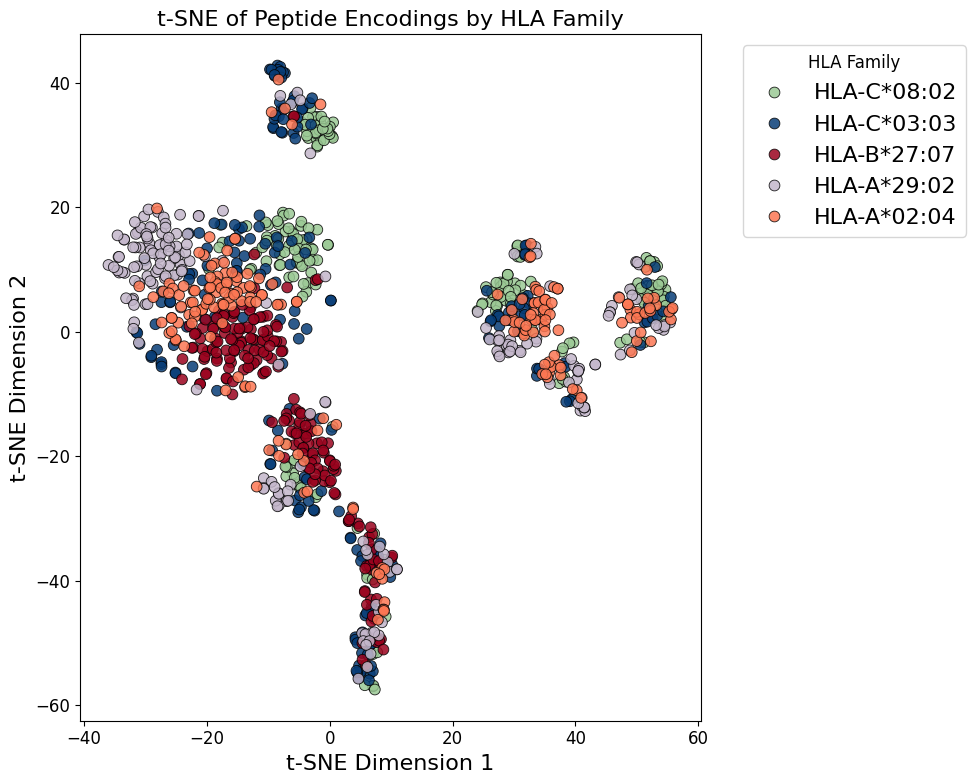

In [24]:
def plot_embedding_by_family(embeddings, families, method="t-SNE", title=None):
    """
    Plot 2D embeddings (t-SNE or UMAP) colored by HLA family.
    
    embeddings: np.array of shape (n_samples, 2)
    families: list or array of HLA family labels
    method: "t-SNE" or "UMAP"
    title: optional custom title
    """
    if title is None:
        title = f"{method} of Peptide Encodings by HLA Family"

    df = pd.DataFrame({
        f'{method}1': embeddings[:, 0],
        f'{method}2': embeddings[:, 1],
        'Family': families
    })

    plt.figure(figsize=(10, 8))
    unique_families = df['Family'].unique()
    palette = sns.color_palette(custom_palette, n_colors=len(unique_families))

    sns.scatterplot(
        data=df,
        x=f'{method}1',
        y=f'{method}2',
        hue='Family',
        palette=palette,
        edgecolor='k',
        s=60,
        alpha=0.85
    )

    plt.title(title, fontsize=16)
    plt.xlabel(f"{method} Dimension 1")
    plt.ylabel(f"{method} Dimension 2")
    plt.legend(title="HLA Family", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(False)

    plt.tight_layout()
    plt.show()


# Example usage with t-SNE embeddings
plot_embedding_by_family(encoderTsne2d, labelsSmallHla, method="t-SNE")

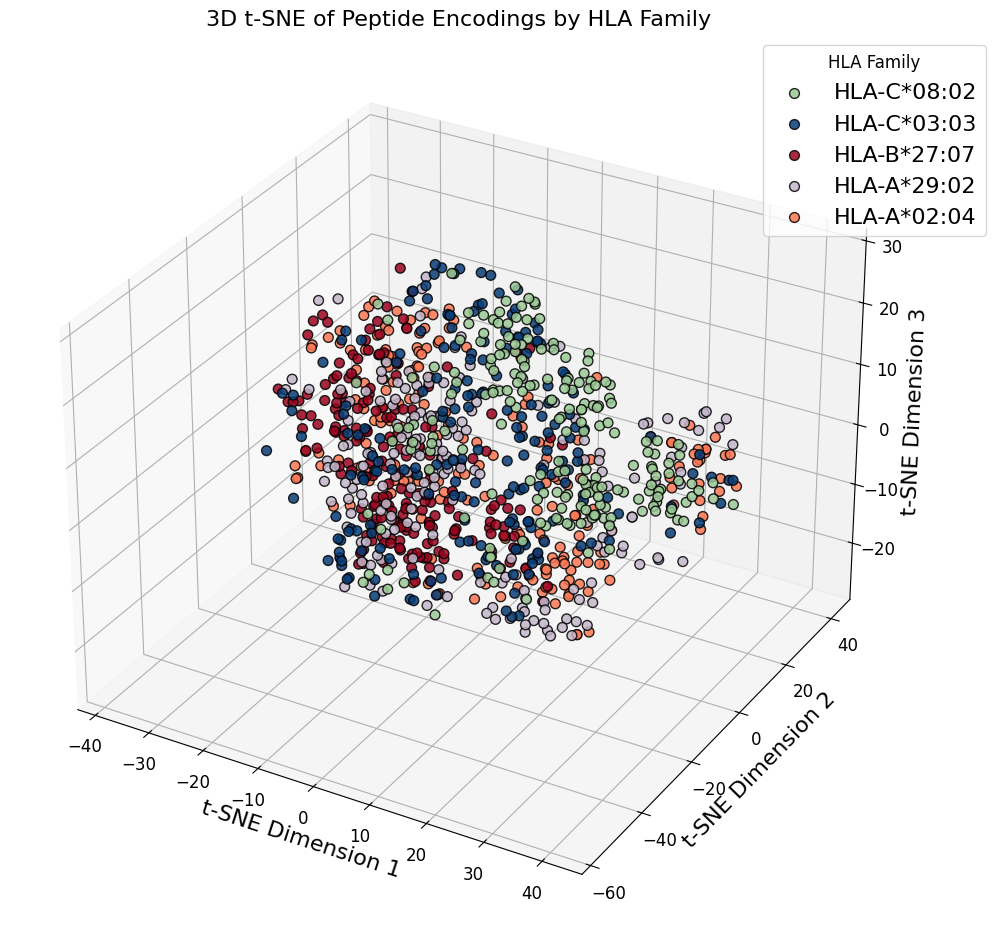

In [27]:
def plot_tsne_3d(embeddingsTSNE, families, title="3D t-SNE of Peptide Encodings by HLA Family"):
    df = pd.DataFrame({
        'TSNE1': embeddingsTSNE[:, 0],
        'TSNE2': embeddingsTSNE[:, 1],
        'TSNE3': embeddingsTSNE[:, 2],
        'Family': families
    })

    unique_families = df['Family'].unique()
    palette = sns.color_palette(custom_palette, n_colors=len(unique_families))
    color_dict = dict(zip(unique_families, palette))

    fig = plt.figure(figsize=(10, 18))
    ax = fig.add_subplot(111, projection='3d')

    for fam in unique_families:
        data_fam = df[df['Family'] == fam]
        ax.scatter(
            data_fam['TSNE1'], data_fam['TSNE2'], data_fam['TSNE3'],
            label=fam,
            color=color_dict[fam],
            edgecolor='k',
            s=50,
            alpha=0.85
        )

    ax.set_title(title, fontsize=16)
    ax.set_xlabel("t-SNE Dimension 1")
    ax.set_ylabel("t-SNE Dimension 2")
    ax.set_zlabel("t-SNE Dimension 3")
    ax.legend(title="HLA Family", bbox_to_anchor=(1.1, 1))
    plt.tight_layout()
    plt.show()

# Call the function
plot_tsne_3d(encoderTsne3d, labelsSmallHla)


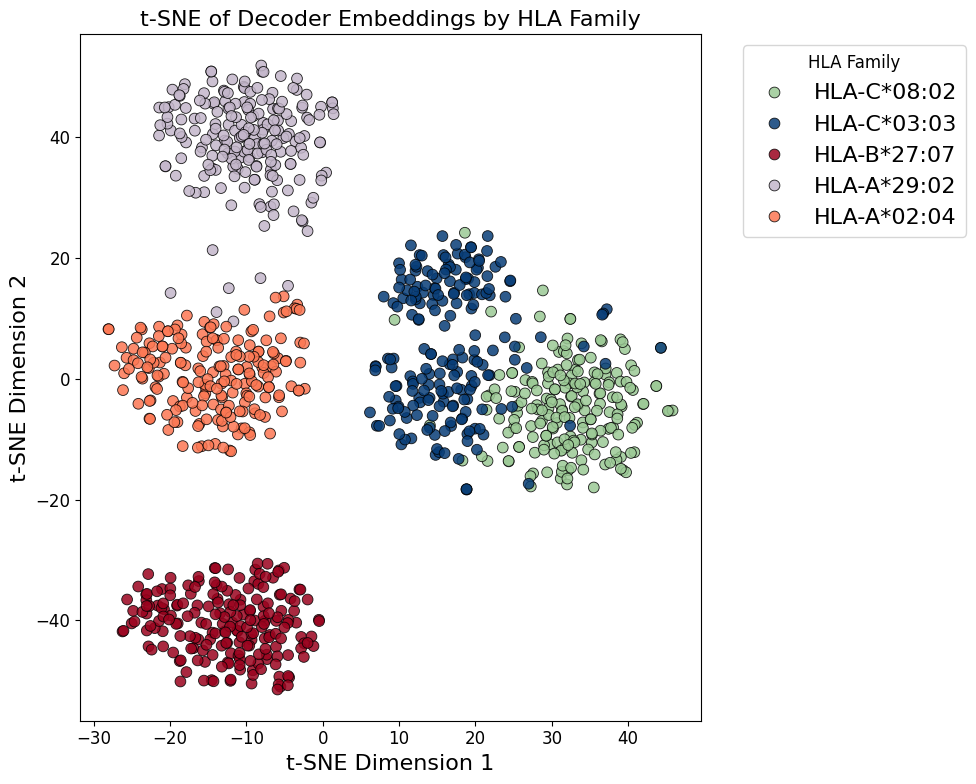

In [28]:
plot_embedding_by_family(decoderTsne2d, labelsSmallHla, method="t-SNE", title="t-SNE of Decoder Embeddings by HLA Family")

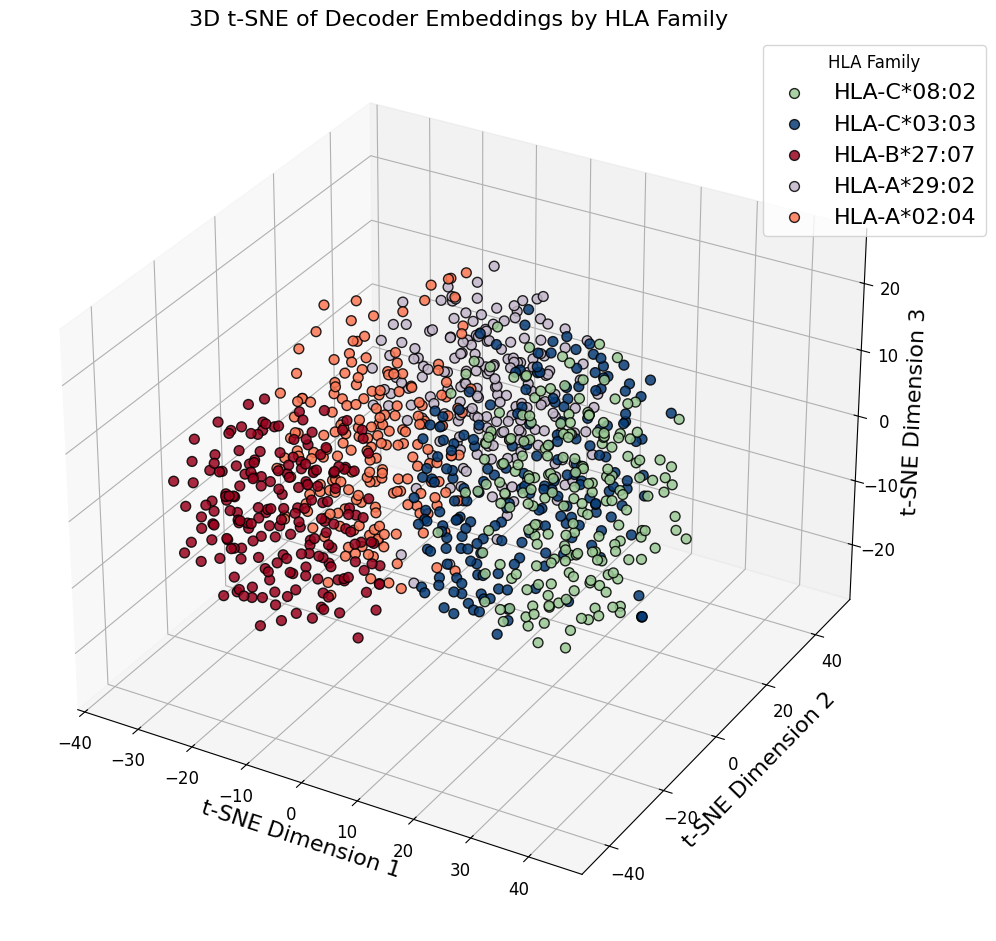

In [30]:
plot_tsne_3d(decoderTsne3d, labelsSmallHla, title="3D t-SNE of Decoder Embeddings by HLA Family")

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from matplotlib.colors import LinearSegmentedColormap

# Encode labels to numeric for sorting
labelEncoder = LabelEncoder()
labelIds = labelEncoder.fit_transform(labelsSmallHla)
sortedIndices = np.argsort(labelIds)

# Step 2: Sort embeddings and labels
embeddingsSorted = pepEncoderOutputs[sortedIndices]
labelsSorted = np.array(labels)[sortedIndices]
labelIdsSorted = labelIds[sortedIndices]

# Step 3: Compute cosine similarity matrix
simMatrix = cosine_similarity(embeddingsSorted)
adjustedSim = np.power(simMatrix, 5)

# Step 4: Plot heatmap with family boundaries
plt.figure(figsize=(10, 8))
white_blue = LinearSegmentedColormap.from_list("white_blue", ["white",  "#083D77"])
sns.heatmap(adjustedSim, cmap=white_blue, square=True, xticklabels=False, yticklabels=False)
plt.title("Cosine Similarity Between Peptides (Sorted by Family)")

# Step 5: Draw lines to show family boundaries
familySizes = np.bincount(labelIdsSorted)
boundaryPositions = np.cumsum(familySizes)

# Use LabelEncoder's classes (sorted unique labels) instead of unique from labelsSorted
uniqueLabels = labelEncoder.classes_

# Compute midpoints for label placement on axes
startIndices = np.insert(boundaryPositions[:-1], 0, 0)
endIndices = boundaryPositions
midpoints = (startIndices + endIndices) // 2

plt.xticks(midpoints, uniqueLabels, rotation=90)
plt.yticks(midpoints, uniqueLabels)

# Draw boundary lines
for pos in boundaryPositions[:-1]:  # skip the last position
    plt.axhline(pos, color='black', linewidth=1)
    plt.axvline(pos, color='black', linewidth=1)

plt.tight_layout()
plt.show()


#### Subplots for Poster

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

def plot_combined_umaps(encoderUmap2d, encoderUmap3d, decoderUmap2d, decoderUmap3d, families, custom_palette):
    # Unique families and color mapping
    unique_families = pd.Series(families).unique()
    palette = sns.color_palette(custom_palette, n_colors=len(unique_families))
    color_dict = dict(zip(unique_families, palette))

    # Create figure and custom grid (wider columns for 3D)
    fig = plt.figure(figsize=(14, 14))
    gs = gridspec.GridSpec(2, 4)  # 4 columns: 0-1 for 2D, 2-3 for 3D

    # 2D Encoder
    ax1 = fig.add_subplot(gs[0, 0:2])
    df1 = pd.DataFrame({'UMAP1': encoderUmap2d[:, 0], 'UMAP2': encoderUmap2d[:, 1], 'Family': families})
    sns.scatterplot(
        data=df1,
        x='UMAP1', y='UMAP2',
        hue='Family',
        palette=color_dict,
        edgecolor='k',
        s=60,
        alpha=0.85,
        ax=ax1,
        legend=False
    )
    ax1.set_title("Encoder UMAP 2D")
    ax1.set_xlabel("UMAP Dimension 1")
    ax1.set_ylabel("UMAP Dimension 2")

    # 3D Encoder
    ax2 = fig.add_subplot(gs[0, 2:4], projection='3d')
    df2 = pd.DataFrame({'UMAP1': encoderUmap3d[:, 0], 'UMAP2': encoderUmap3d[:, 1], 'UMAP3': encoderUmap3d[:, 2], 'Family': families})
    for fam in unique_families:
        data_fam = df2[df2['Family'] == fam]
        ax2.scatter(data_fam['UMAP1'], data_fam['UMAP2'], data_fam['UMAP3'],
                    color=color_dict[fam], label=fam, edgecolor='k', s=50, alpha=0.85)
    ax2.set_title("Encoder UMAP 3D")
    ax2.set_xlabel("UMAP Dimension 1")
    ax2.set_ylabel("UMAP Dimension 2")
    ax2.set_zlabel("UMAP Dimension 3")

    # 2D Decoder
    ax3 = fig.add_subplot(gs[1, 0:2])
    df3 = pd.DataFrame({'UMAP1': decoderUmap2d[:, 0], 'UMAP2': decoderUmap2d[:, 1], 'Family': families})
    sns.scatterplot(
        data=df3,
        x='UMAP1', y='UMAP2',
        hue='Family',
        palette=color_dict,
        edgecolor='k',
        s=60,
        alpha=0.85,
        ax=ax3,
        legend=False
    )
    ax3.set_title("Decoder UMAP 2D")
    ax3.set_xlabel("UMAP Dimension 1")
    ax3.set_ylabel("UMAP Dimension 2")

    # 3D Decoder
    ax4 = fig.add_subplot(gs[1, 2:4], projection='3d')
    df4 = pd.DataFrame({'UMAP1': decoderUmap3d[:, 0], 'UMAP2': decoderUmap3d[:, 1], 'UMAP3': decoderUmap3d[:, 2], 'Family': families})
    for fam in unique_families:
        data_fam = df4[df4['Family'] == fam]
        ax4.scatter(data_fam['UMAP1'], data_fam['UMAP2'], data_fam['UMAP3'],
                    color=color_dict[fam], label=fam, edgecolor='k', s=50, alpha=0.85)
    ax4.set_title("Decoder UMAP 3D")
    ax4.set_xlabel("UMAP Dimension 1")
    ax4.set_ylabel("UMAP Dimension 2")
    ax4.set_zlabel("UMAP Dimension 3")

    # Legend: slightly bigger
    handles = [
        plt.Line2D([0], [0], marker='o', color='w',
                   label=fam, markerfacecolor=color_dict[fam],
                   markeredgecolor='k', markersize=9)  
        for fam in unique_families
    ]
    fig.legend(
        handles, unique_families,
        title="HLA Family", loc='upper right',
        bbox_to_anchor=(1.0, 1.0),
        fontsize=11,           
        title_fontsize=12
    )

    plt.subplots_adjust(wspace=0.4, hspace=0.3, right=0.87)
    plt.show()


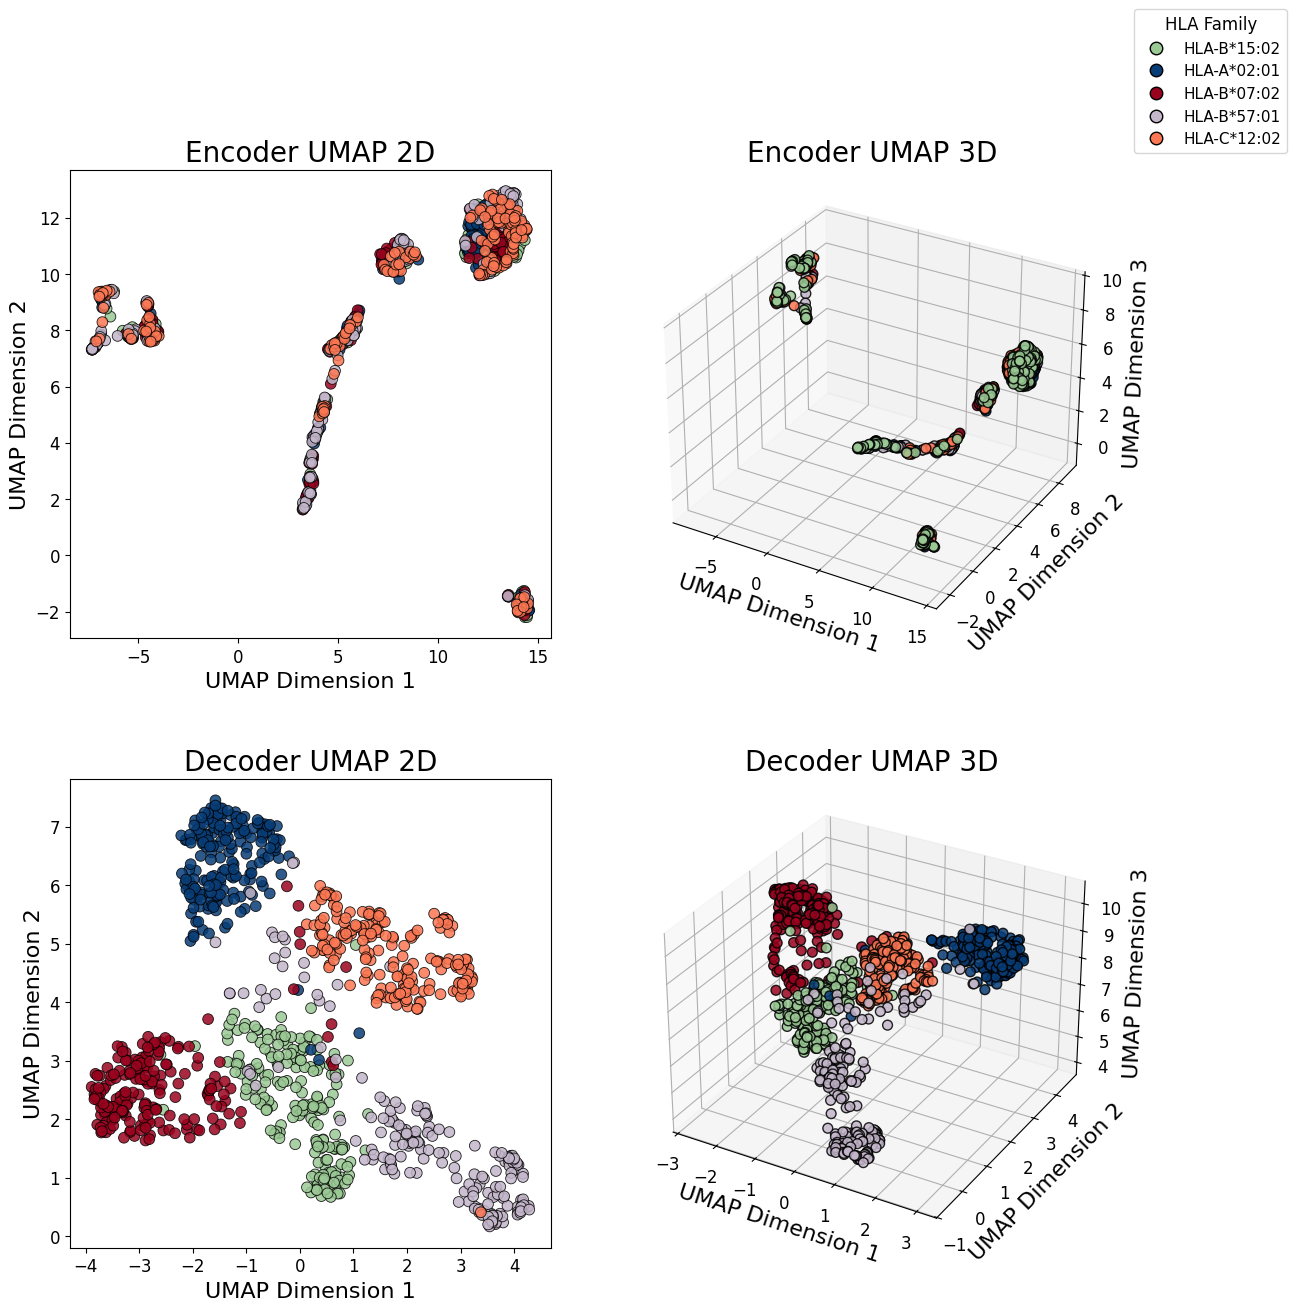

In [ ]:
plot_combined_umaps(encoderUmap2d, encoderUmap3d, decoderUmap2d, decoderUmap3d, labelsSmallHla, custom_palette)


In [ ]:
def plot_umap_3d_side_by_side(encoderUmap3d, decoderUmap3d, families, custom_palette):
    unique_families = pd.Series(families).unique()
    palette = sns.color_palette(custom_palette, n_colors=len(unique_families))
    color_dict = dict(zip(unique_families, palette))

    fig = plt.figure(figsize=(14, 7))  # Wider figure for side-by-side layout

    # Encoder 3D plot
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    df_enc = pd.DataFrame({
        'UMAP1': encoderUmap3d[:, 0],
        'UMAP2': encoderUmap3d[:, 1],
        'UMAP3': encoderUmap3d[:, 2],
        'Family': families
    })
    for fam in unique_families:
        data = df_enc[df_enc['Family'] == fam]
        ax1.scatter(data['UMAP1'], data['UMAP2'], data['UMAP3'],
                    color=color_dict[fam], label=fam,
                    edgecolor='k', s=50, alpha=0.85)
    ax1.set_title("Encoder UMAP 3D")
    ax1.set_xlabel("UMAP 1")
    ax1.set_ylabel("UMAP 2")
    ax1.set_zlabel("UMAP 3")

    # Decoder 3D plot
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    df_dec = pd.DataFrame({
        'UMAP1': decoderUmap3d[:, 0],
        'UMAP2': decoderUmap3d[:, 1],
        'UMAP3': decoderUmap3d[:, 2],
        'Family': families
    })
    for fam in unique_families:
        data = df_dec[df_dec['Family'] == fam]
        ax2.scatter(data['UMAP1'], data['UMAP2'], data['UMAP3'],
                    color=color_dict[fam], label=fam,
                    edgecolor='k', s=50, alpha=0.85)
    ax2.set_title("Decoder UMAP 3D")
    ax2.set_xlabel("UMAP 1")
    ax2.set_ylabel("UMAP 2")
    ax2.set_zlabel("UMAP 3")

    # Shared legend
    handles = [
        plt.Line2D([0], [0], marker='o', color='w',
                   label=fam, markerfacecolor=color_dict[fam],
                   markeredgecolor='k', markersize=8)
        for fam in unique_families
    ]
    fig.legend(handles, unique_families, title="HLA Family",
               bbox_to_anchor=(0.92, 0.95), fontsize=10, title_fontsize=11)

    plt.tight_layout()
    plt.show()

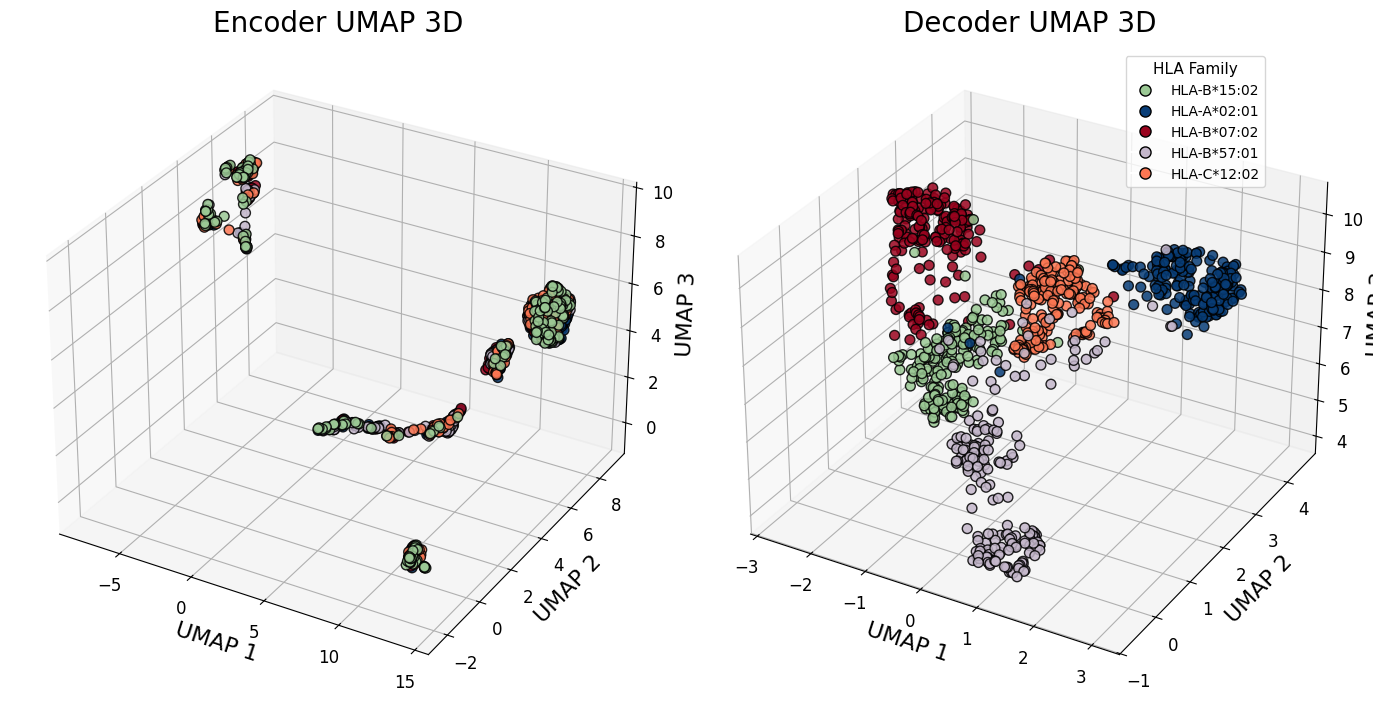

In [ ]:
plot_umap_3d_side_by_side(encoderUmap3d, decoderUmap3d, labelsSmallHla, custom_palette)


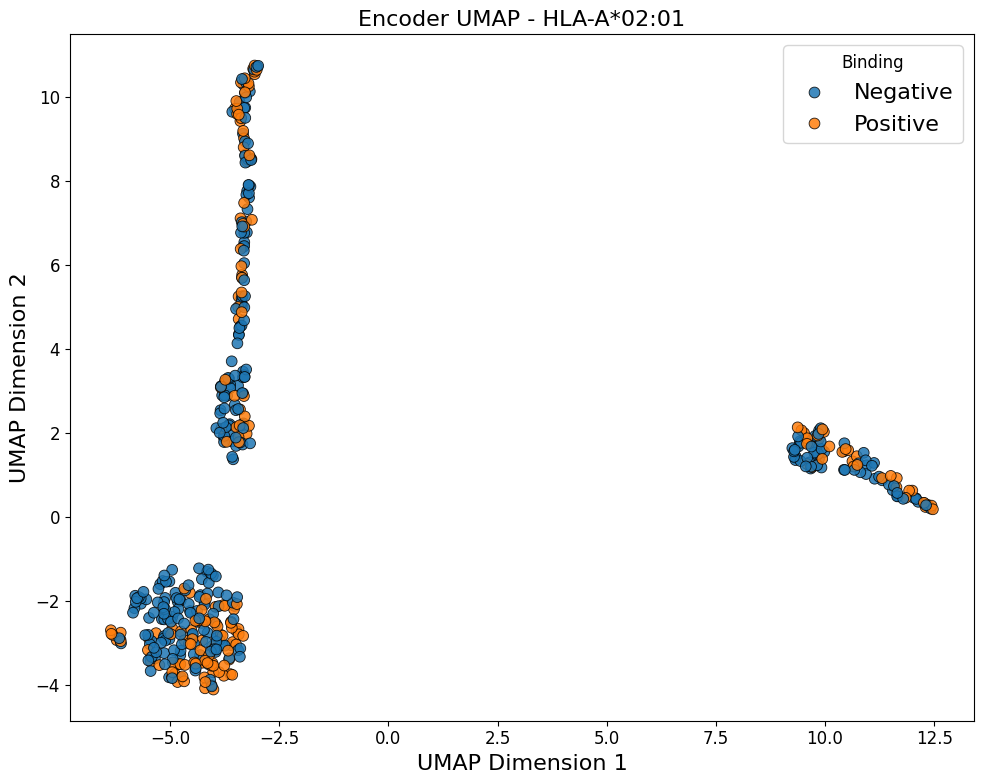

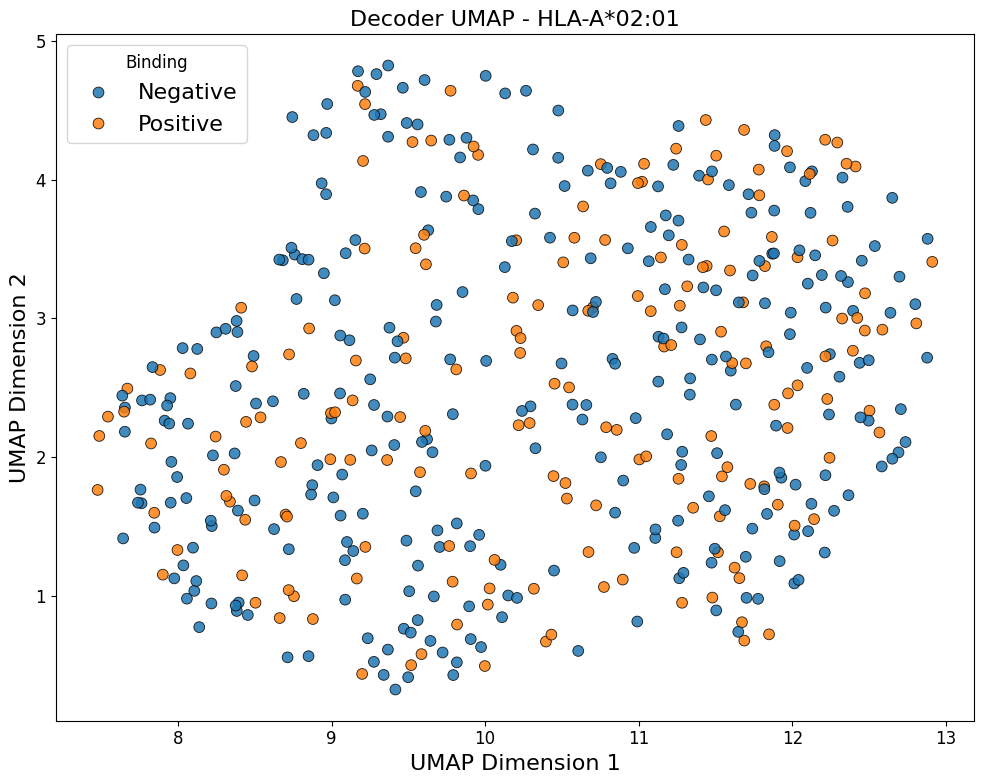

In [ ]:
import pandas as pd
import numpy as np
import torch
import umap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

# Device 
device = "cuda" if torch.cuda.is_available() else "cpu"

# Prepare data
data = pd.read_csv('data/testData/testData.csv')
pep_inputs, hla_inputs, labels, labelsHla = make_data(data, True)

# Filter only HLA-A*02:01
hla_mask = labelsHla == "HLA-A*02:01"
pep_hla = pep_inputs[hla_mask]       # tensor of token IDs
hla_hla = hla_inputs[hla_mask]       # tensor of token IDs
labels_hla = labels[hla_mask]        # tensor of 0/1
pep_seq_hla = np.array(data.peptide)[hla_mask]  # strings only for labeling

# Sample N sequences
N = 500
num_samples = min(N, len(pep_hla))

pepSmall = pep_hla[:num_samples].to(device)
hlaSmall = hla_hla[:num_samples].to(device)
labelsSmall = labels_hla[:num_samples].cpu().numpy()
pepSmallSeq = pep_seq_hla[:num_samples]  


#Load model and extract encoder outputs 
model = Transformer(d_model, d_k, n_layers, n_heads, d_ff, dropout=dropout)
model.load_state_dict(torch.load("model/best_model_final.pt", map_location=device))
model.to(device)
model.eval()

pepEncoderOutputs = {}
decOutputs = {}

# Encoder hook
def get_encoder_hook(name):
    def hook(model, input, output):
        # output may be tensor or tuple/list
        if isinstance(output, (tuple, list)):
            for o in output:
                if torch.is_tensor(o):
                    pepEncoderOutputs["pep"] = o.detach()
                    break
        elif torch.is_tensor(output):
            pepEncoderOutputs["pep"] = output.detach()
        else:
            print("Encoder hook got non-tensor output:", type(output))
    return hook

# Decoder hook
def get_decoder_hook(name):
    def hook(model, input, output):
        if isinstance(output, (tuple, list)):
            for o in output:
                if torch.is_tensor(o):
                    decOutputs["dec"] = o.detach()
                    break
        elif torch.is_tensor(output):
            decOutputs["dec"] = output.detach()
        else:
            print("Decoder hook got non-tensor output:", type(output))
    return hook

model.pep_encoder.register_forward_hook(get_encoder_hook("pep_encoder"))
model.decoder.register_forward_hook(get_decoder_hook("decoder"))

# Forward pass
with torch.no_grad():
    _ = model(pepSmall, hlaSmall)

pepEncoderOutputs = pepEncoderOutputs["pep"]
decOutputs = decOutputs["dec"]

# Flatten embeddings and apply UMAP
pepEncoderOutputs_flat = pepEncoderOutputs.flatten(start_dim=1).cpu().numpy()
decOutputs_flat = decOutputs.flatten(start_dim=1).cpu().numpy()

reducer2d = umap.UMAP(n_components=2, random_state=42)

encoderUmap2d = reducer2d.fit_transform(pepEncoderOutputs_flat)
decoderUmap2d = reducer2d.fit_transform(decOutputs_flat)

#  Remove outliers 
def remove_outliers(embedding, labels, percentage=5, n_neighbors=50):
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=percentage/100)
    mask = lof.fit_predict(embedding) == 1
    return embedding[mask], np.array(labels)[mask]

encoderUmap2d, labelsSmall_filtered = remove_outliers(encoderUmap2d, labelsSmall, percentage=5)
decoderUmap2d, _ = remove_outliers(decoderUmap2d, labelsSmall, percentage=5)

#Plot UMAP colored by positive/negative
def plot_umap_by_label(embeddings, labels, title="UMAP of Peptide Encodings"):
    df = pd.DataFrame({
        'UMAP1': embeddings[:, 0],
        'UMAP2': embeddings[:, 1],
        'Label': ["Positive" if l==1 else "Negative" for l in labels]
    })

    plt.figure(figsize=(10, 8))
    palette = ["tab:blue", "tab:orange"]

    sns.scatterplot(
        data=df,
        x='UMAP1', y='UMAP2',
        hue='Label',
        palette=palette,
        edgecolor='k',
        s=60,
        alpha=0.85
    )

    plt.title(title, fontsize=16)
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.legend(title="Binding")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# --- Plot encoder and decoder embeddings ---
plot_umap_by_label(encoderUmap2d, labelsSmall_filtered, title="Encoder UMAP - HLA-A*02:01")
plot_umap_by_label(decoderUmap2d, labelsSmall_filtered, title="Decoder UMAP - HLA-A*02:01")


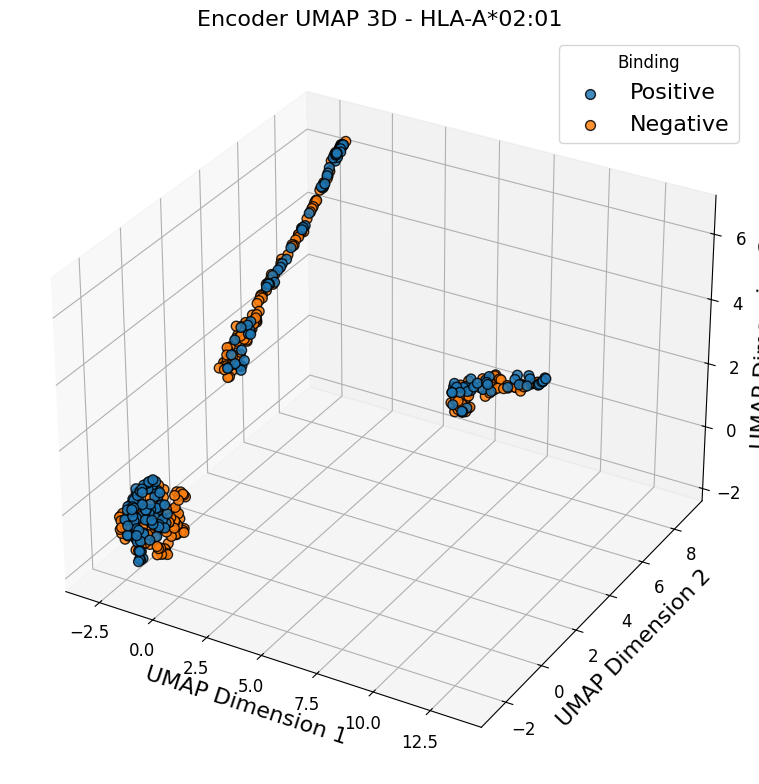

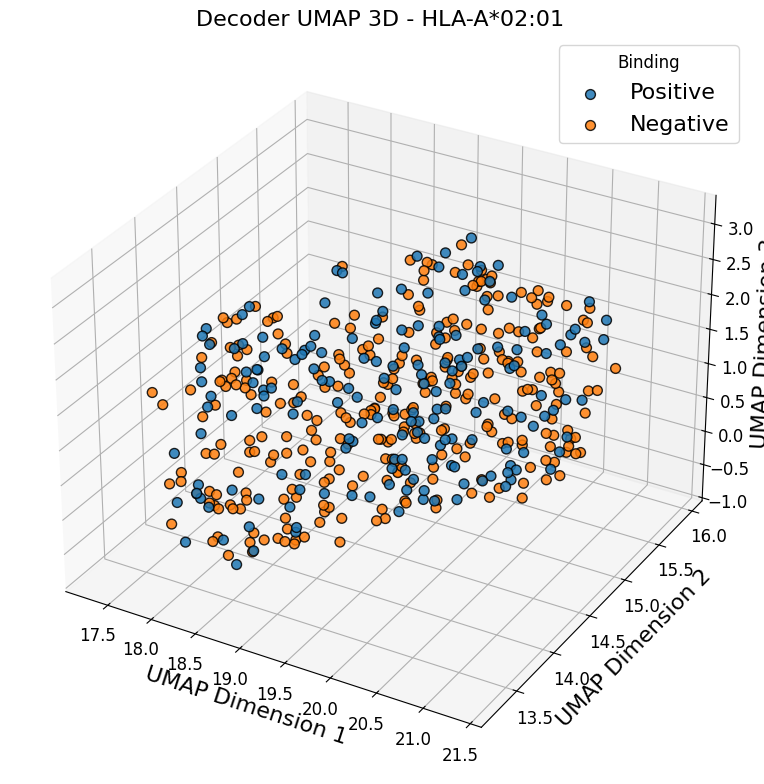

In [ ]:
import pandas as pd
import numpy as np
import torch
import umap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

device = "cuda" if torch.cuda.is_available() else "cpu"

data = pd.read_csv('data/testData/testData.csv')
pep_inputs, hla_inputs, labels, labelsHla = make_data(data, True)

# Filter only HLA-A*02:01
hla_mask = labelsHla == "HLA-A*02:01"
pep_hla = pep_inputs[hla_mask]       # tensor of token IDs
hla_hla = hla_inputs[hla_mask]       # tensor of token IDs
labels_hla = labels[hla_mask]        # tensor of 0/1
pep_seq_hla = np.array(data.peptide)[hla_mask]  # strings only for labeling

# Sample N sequences while keeping correspondence
N = 500
num_samples = min(N, len(pep_hla))

pepSmall = pep_hla[:num_samples].to(device)
hlaSmall = hla_hla[:num_samples].to(device)
labelsSmall = labels_hla[:num_samples].cpu().numpy()
pepSmallSeq = pep_seq_hla[:num_samples]  # keep strings for plotting


# Load model and extract encoder + decoder outputs 
model = Transformer(d_model, d_k, n_layers, n_heads, d_ff, dropout=dropout)
model.load_state_dict(torch.load("model/best_model_final.pt", map_location=device))
model.to(device)
model.eval()

pepEncoderOutputs = {}
decOutputs = {}

# Encoder hook
def get_encoder_hook(name):
    def hook(model, input, output):
        if isinstance(output, (tuple, list)):
            for o in output:
                if torch.is_tensor(o):
                    pepEncoderOutputs["pep"] = o.detach()
                    break
        elif torch.is_tensor(output):
            pepEncoderOutputs["pep"] = output.detach()
    return hook

# Decoder hook
def get_decoder_hook(name):
    def hook(model, input, output):
        if isinstance(output, (tuple, list)):
            for o in output:
                if torch.is_tensor(o):
                    decOutputs["dec"] = o.detach()
                    break
        elif torch.is_tensor(output):
            decOutputs["dec"] = output.detach()
    return hook

model.pep_encoder.register_forward_hook(get_encoder_hook("pep_encoder"))
model.decoder.register_forward_hook(get_decoder_hook("decoder"))

with torch.no_grad():
    _ = model(pepSmall, hlaSmall)

pepEncoderOutputs = pepEncoderOutputs["pep"]
decOutputs = decOutputs["dec"]


pepEncoderOutputs_flat = pepEncoderOutputs.flatten(start_dim=1).cpu().numpy()
decOutputs_flat = decOutputs.flatten(start_dim=1).cpu().numpy()

reducer3d = umap.UMAP(n_components=3, random_state=42)
encoderUmap3d = reducer3d.fit_transform(pepEncoderOutputs_flat)
decoderUmap3d = reducer3d.fit_transform(decOutputs_flat)

def remove_outliers(embedding, labels, percentage=5, n_neighbors=50):
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=percentage/100)
    mask = lof.fit_predict(embedding) == 1
    return embedding[mask], np.array(labels)[mask]

encoderUmap3d, labels_filtered = remove_outliers(encoderUmap3d, labelsSmall, percentage=5)
decoderUmap3d, _ = remove_outliers(decoderUmap3d, labelsSmall, percentage=5)


def plot_umap_3d(embeddings, labels, title="3D UMAP of Peptide Encodings"):
    df = pd.DataFrame({
        'UMAP1': embeddings[:, 0],
        'UMAP2': embeddings[:, 1],
        'UMAP3': embeddings[:, 2],
        'Label': ["Positive" if l==1 else "Negative" for l in labels]
    })

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    palette = {"Positive": "tab:blue", "Negative": "tab:orange"}

    for lbl in ["Positive", "Negative"]:
        subset = df[df['Label'] == lbl]
        ax.scatter(
            subset['UMAP1'], subset['UMAP2'], subset['UMAP3'],
            c=palette[lbl], label=lbl,
            edgecolor='k', s=50, alpha=0.85
        )

    ax.set_title(title, fontsize=16)
    ax.set_xlabel("UMAP Dimension 1")
    ax.set_ylabel("UMAP Dimension 2")
    ax.set_zlabel("UMAP Dimension 3")
    ax.legend(title="Binding")
    plt.tight_layout()
    plt.show()

# Plot encoder and decoder embeddings in 3D
plot_umap_3d(encoderUmap3d, labels_filtered, title="Encoder UMAP 3D - HLA-A*02:01")
plot_umap_3d(decoderUmap3d, labels_filtered, title="Decoder UMAP 3D - HLA-A*02:01")
